In [ ]:
# https://fred.stlouisfed.org/series/RSCCASN

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [4]:
df = pd.read_csv('data/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [5]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

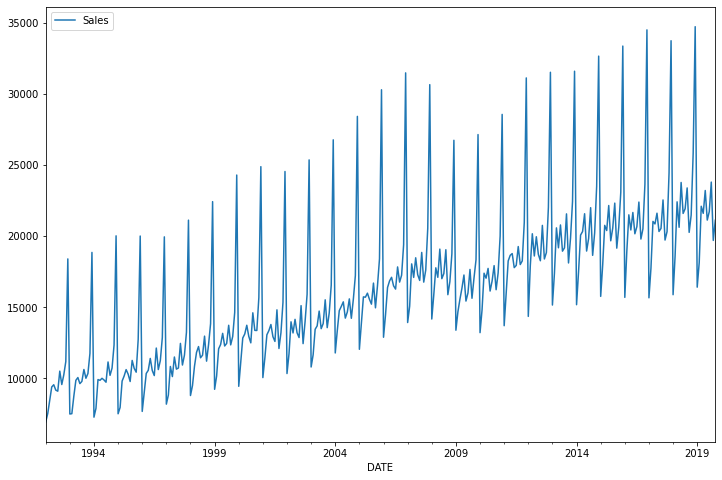

In [32]:
df.plot(figsize=(12,8))

In [7]:
len(df) - 18 #predict next 18 points from this indices

316

In [8]:
test_size=18
test_ind = len(df)-test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [15]:
# Let's define our batches. Add EarlyStopping and Validation Generator

In [16]:
len(test)

18

In [13]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)

In [14]:
X,y = generator[0]

In [15]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [20]:
# y - This is predicting the 13th month

In [22]:
# len(X[0])

In [17]:
n_features = 1

Create the model

In [18]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [21]:
validation_generator = TimeseriesGenerator(scaled_test,
                                          scaled_test,
                                          length=length,
                                          batch_size=1)

In [22]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\antho\AppData\Local\Temp\ipykernel_19620\1950115197.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


304/304 [==============================] - 18s 53ms/step - loss: 0.0231 - val_loss: 0.0038
Epoch 2/20
304/304 [==============================] - 16s 53ms/step - loss: 0.0167 - val_loss: 0.0083
Epoch 3/20
304/304 [==============================] - 15s 51ms/step - loss: 0.0133 - val_loss: 9.5824e-04
Epoch 4/20
304/304 [==============================] - 15s 50ms/step - loss: 0.0053 - val_loss: 0.0169
Epoch 5/20
304/304 [==============================] - 15s 50ms/step - loss: 0.0023 - val_loss: 8.9190e-04
Epoch 6/20
304/304 [==============================] - 16s 52ms/step - loss: 0.0022 - val_loss: 0.0042
Epoch 7/20
304/304 [==============================] - 15s 50ms/step - loss: 0.0014 - val_loss: 2.1011e-04
Epoch 8/20
304/304 [==============================] - 16s 51ms/step - loss: 0.0020 - val_loss: 6.1051e-04
Epoch 9/20
304/304 [==============================] - 16s 52ms/step - loss: 0.0022 - val_loss: 0.0020


In [23]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

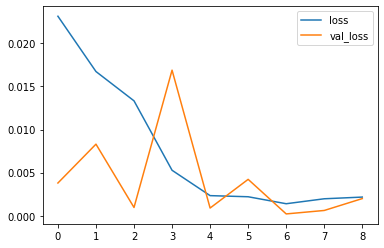

In [24]:
losses.plot()

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
# Grabs the last 12 months of my training set to predict 1 month into the future
current_batch = first_eval_batch.reshape((1, length, n_features))
#reshape the format of the model that's expected from the RNN
for i in range(len(test)):
#     for the entire length of my test set...
    current_pred = model.predict(current_batch)[0]
#     get prediction 1 time stamp ahead [0] is for grabbing just the number
    test_predictions.append(current_pred) 
#     stores the test prediction by appending
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
#     update batch to now include prediction and drop first value

1/1 [==============================] - 0s 17ms/step


In [26]:
true_prediction = scaler.inverse_transform(test_predictions)

In [34]:
test['Predictions']=true_prediction

c:\users\antho\anaconda3\envs\mytfenv\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='DATE'>

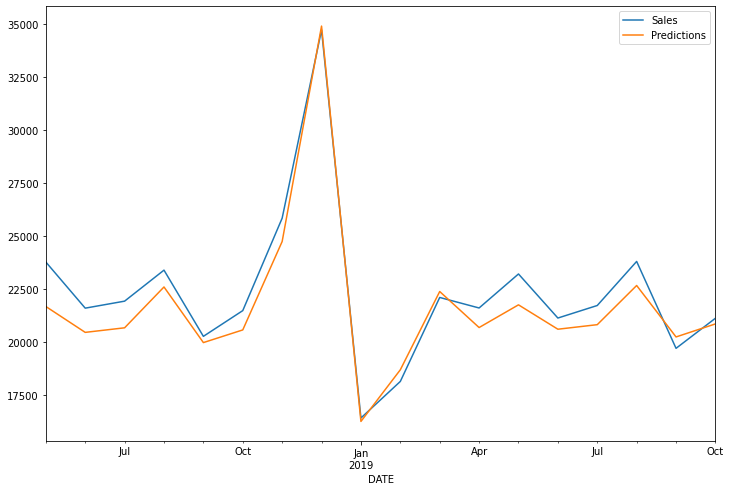

In [35]:
test.plot(figsize=(12,8))

In [36]:
# This network doesn't have a true understanding like holidays. It's learning
# based off the previous cycle.

In [37]:
# Let's try to forecast into the unknown future.

In [38]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [39]:
length = 12
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                               length=length,batch_size=1)

In [40]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model.fit_generator(generator,epochs=8)
# We don't use EarlyStopping in the full data because if we recall on the 
# validation generator, we had data set aside that should be untouched. Since 
# we're using the full dataset, we want to take all our data to predict to the
# unknown future. Why we use earlystopping for validation is to find # of epochs

c:\users\antho\anaconda3\envs\mytfenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
322/322 [==============================] - 3s 6ms/step - loss: 0.0242
Epoch 2/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0196
Epoch 3/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0158
Epoch 4/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0067A: 0s - loss: 
Epoch 5/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0048
Epoch 6/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0023
Epoch 7/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0017


In [41]:
forecast = []
periods = 12
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [42]:
forecast = scaler.inverse_transform(forecast)

In [43]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [44]:
forecast

array([[21129.62317705],
       [20202.35027432],
       [20458.72272325],
       [21996.83346462],
       [19910.53982353],
       [20472.75065899],
       [23759.01275444],
       [32516.73291016],
       [16089.35196233],
       [18470.88977504],
       [21626.89786148],
       [20213.19321442]])

In [45]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,
                              freq='MS')

In [46]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                          columns=['Forecast'])

In [47]:
forecast_df

,Forecast
2019-11-01,21129.623177
2019-12-01,20202.350274
2020-01-01,20458.722723
2020-02-01,21996.833465
2020-03-01,19910.539824
2020-04-01,20472.750659
2020-05-01,23759.012754
2020-06-01,32516.732910
2020-07-01,16089.351962
2020-08-01,18470.889775


(576.0, 611.0)

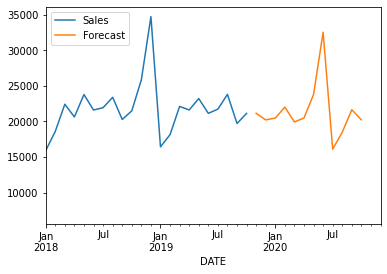

In [48]:
# df.plot()
# forecast_df.plot()
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')